# Stepik ML Contest
Практическим проектом нашего [курса](https://stepik.org/course/4852/syllabus) будет анализ активности студентов онлайн курса "Введение в анализ данных в R".

Описание данных:
- [**events_train.csv**](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами.
    1. step_id - id стэпа
    2. user_id - анонимизированный id юзера
    3. timestamp - время наступления события в формате unix date
    4. action - событие, возможные значения: 
        - discovered - пользователь перешел на стэп
        - viewed - просмотр шага,
        - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
        - passed - удачное решение практического шага. 
- [**submissions_train.csv**](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям.
    1. step_id - id стэпа
    2. timestamp - время отправки решения в формате unix date
    3. submission_status - статус решения
    4. user_id - анонимизированный id юзера

### Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:
- [submission_data_test.csv](https://stepik.org/media/attachments/course/4852/submission_data_test.csv)
- [events_data_test.csv](https://stepik.org/media/attachments/course/4852/events_data_test.csv)

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019.

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

## Соревнование начинается
<hr>

## 1. Построение baseline решения задачи.
Итак, у нас есть информация о том, какую активность проявляли пользователи за 2015-2018 года на курсе по "Введению в анализ данных на R" в виде датасета events_train. Также нам даны данные о попытках закрыть задачу в виде датафрейма submissions_train.
<br>Наша задача состоит в предсказании: пройдет ли студент курс на 40 баллов или же уйдет с курса. Предсказать его поведение нужно за первые два дня, проведенные на курсе.

В первую очередь определим, **что значит, что студент ушел с курса?** В принципе, мы можем взять какое-то определенное число, например 1 месяц, но было бы неплохо, если бы мы выяснили это каким-то вещим образом. Можем посчитать 90 и 95 персентиль и посчитать их среднее.

Теперь выясним, **какие данные могут помочь нам провести анализ за первые 2 дня и сделать предсказание?**:
<br>На самом деле, не так много. Как бы круто не была устроена модель, будем ориентироваться на адекватные возможности уместить данные за первые два дня.
- В качестве переменных для **y** мы возьмем значение переменной *passed_course* - прошел ли студент курс (на 40+ баллов).
- В **Х** мы можем сложить:
    1. **user_id** - идентификаторы пользователя, как индексы.
    2. **unique_days** - Количество уникальных проведенных на курсе дней (за первые дня дня). Максимум - это три дня (т.к. двое суток могут охватить 3 дня). Таким образом можно выяснить, насколько активен пользователь был в первые дни на курсе.
    3. Количество совершенных действий каждого типа action. Как и для предыдущего пункта. Пользователь мог отвалиться на каком то этапе.
    4. Количество правильно и неправильно решенных степов, а также процентное соотношение правильных попыток ко всем попыткам. Эти данные могут помочь словить "сгоревших" пользователей.
    5. **steps_tried** - В целом, количество шагов, которые пользователь попробовал решить.

В принципе, только такие данные мы и можем синтезировать из наших датасетов. Правда можно еще взять и учесть последний попробованный степ, для каждого пользователя. Может быть мы сумеем обнаружить такой степ, на котором много людей отсеиваются.

## 2. Первичный анализ и предобработка данных
Ключевые аналитические моменты мы выделили, теперь проведем предобработку данных, проанализируем датасеты на адекватность, и посчитаем данные об успеваемости пользователей за все время. Также не забываем обращать внимание на сохранность наших данных, чтобы мы не потеряли никаких нужных наблюдений и не убрали ничего лишнего.

Импортируем библиотеки и загрузим все данные.

In [113]:
# Библиотеки
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Данные
events_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip", compression="zip")
submissions_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip", compression="zip")

### Сперва поработаем с events_data
Изучим и проанализируем данные, оценим их на адекватность.

In [114]:
events_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


Добавим столбец для сохранения даты и посмотрим, за какое время у нас хранятся данные.

In [115]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit="s")
events_data

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30


Добавим столбец для хранения дня активности.

In [116]:
events_data["day"] = events_data.date.dt.date
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


Взглянем на минимальную и максимальную дату.

In [117]:
print(f"Min day: {events_data.day.min()}.")
print(f"Max day: {events_data.day.max()}.")

Min day: 2015-06-15.
Max day: 2018-05-19.


Данные за три года. Видимо все хорошо.

Посмотрим на активность пользователей в каждый имеющийся в датасете день.

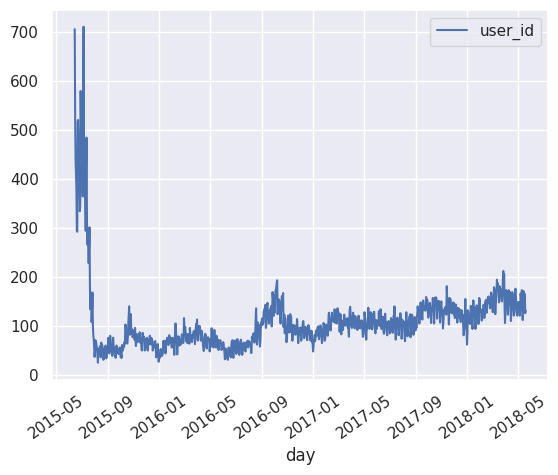

In [118]:
events_data\
    .groupby("day")\
    .agg({"user_id": "nunique"})\
    .plot().tick_params(axis="x", rotation=35)

Можно заметить высокую активность в первые дни и падение активности после. Выглядит логично.

Взглянем на общее число пользователей.

In [119]:
events_data.user_id.nunique()

19234

Всего мы имеем **19234** пользователей.

### Изучим перерывы.
Теперь изучим информацию о том, какие перерывы делали студенты между днями активности.

In [120]:
gap_data = events_data[["user_id", "day", "timestamp"]]\
    .drop_duplicates(["user_id", "day"])\
    .groupby("user_id")["timestamp"]\
    .apply(list)\
    .apply(np.diff)\
    .values

gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

Объединим все эти данные в единый pd.Series

In [121]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Взглянем на распределение перерывов в днях (возьмем данные с учетом до 200 дней перерыва, ибо дальше пользователь скорее всего точно не вернется на курс.)

<Axes: >

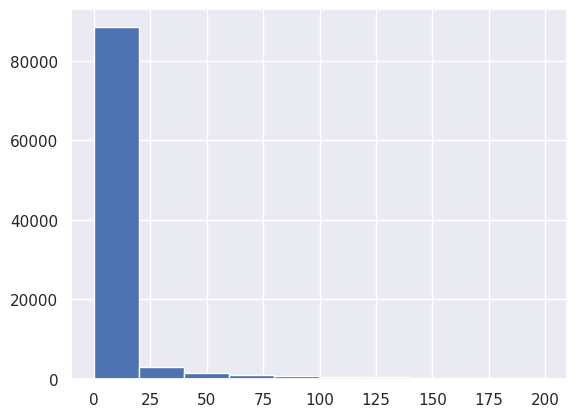

In [122]:
gap_data[gap_data < 200].hist()

In [123]:
gap_90 = gap_data.quantile(0.90)
gap_95 = gap_data.quantile(0.95)

print(f'90% квантиль: {gap_90}.')
print(f'95% квантиль: {gap_95}.')

90% квантиль: 18.325995370370403.
95% квантиль: 59.760440972222156.


Возьмем среднее из этих двух величин.

In [124]:
drop_out_threshold_in_days = int((gap_90 + gap_95) / 2)
drop_out_threshold_in_days

39

In [125]:
drop_out_threshold = drop_out_threshold_in_days * 24 * 3600
drop_out_threshold

3369600

Также найдем максимальный таймстемп, который примем за текущее время.

In [126]:
last_timestamp = events_data.timestamp.max()
last_timestamp

1526772811

Самое время создать новый датафрейм, чтобы сохранить в него данные.
<br>Сохраним информацию о последнем посещении курса.

In [127]:
users_data = events_data.groupby("user_id", as_index=False)\
    .agg({"timestamp": "max"})\
    .rename(columns={"timestamp": "last_timestamp"})

users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


Теперь выясним, какие пользователи покинули курс, а какие - нет, в зависимости от их последнего посещения курса.

In [128]:
users_data["is_gone_user"] = (last_timestamp - users_data.last_timestamp) > drop_out_threshold
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


Также взглянем на количество пройденных степов.

In [129]:
users_passed = events_data.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()[["user_id", "passed"]]

users_passed

action,user_id,passed
0,1,0
1,2,9
2,3,87
3,5,11
4,7,1
...,...,...
19229,26790,8
19230,26793,0
19231,26794,69
19232,26797,10


Присоединим эту информацию к нашему датафрейму

In [130]:
users_data = users_data.merge(users_passed).rename(columns={"passed": "steps_passed"})
users_data

,user_id,last_timestamp,is_gone_user,steps_passed
0,1,1472827464,True,0
1,2,1519226966,True,9
2,3,1444581588,True,87
3,5,1499859939,True,11
4,7,1521634660,True,1
...,...,...,...,...
19229,26790,1517495987,True,8
19230,26793,1510225034,True,0
19231,26794,1512035039,True,69
19232,26797,1509995096,True,10


А теперь сохраним данные о том, прошел ли пользователь курс или нет.

In [131]:
users_data["passed_course"] = (users_data.steps_passed >= 40)
users_data

,user_id,last_timestamp,is_gone_user,steps_passed,passed_course
0,1,1472827464,True,0,False
1,2,1519226966,True,9,False
2,3,1444581588,True,87,True
3,5,1499859939,True,11,False
4,7,1521634660,True,1,False
...,...,...,...,...,...
19229,26790,1517495987,True,8,False
19230,26793,1510225034,True,0,False
19231,26794,1512035039,True,69,True
19232,26797,1509995096,True,10,False


Мы собрали необходимую информацию о пользователях касательно их успеваемости и активности за все время. Теперь мы готовы к формированию обучающего датасета.

## 3. Формирование обучающего датасета.
В данной главе мы наконец-то перейдем к формированию датасета для обучения нашей модели. У нас есть информация о том, закончил ли студент курс или нет. Теперь создадим датасет, которых хранит в себе информацию за первые 2 суток активности пользователя и пустим его для обучения.

In [132]:
# Количество дней для учета
learning_days = 2
learning_threshold = learning_days * 24 * 60 * 60